In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import models
from keras import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.metrics import AUC
from keras.regularizers import L1

In [2]:
colnames=['ID', 'Social network', 'Sentiment', 'Text'] 

In [3]:
df_train = pd.read_csv('twitter_training.csv', names=colnames, header=None)
df_val = pd.read_csv('twitter_validation.csv', names=colnames, header=None)

In [4]:
df_train.head(5)

,ID,Social network,Sentiment,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              74682 non-null  int64 
 1   Social network  74682 non-null  object
 2   Sentiment       74682 non-null  object
 3   Text            73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [6]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              1000 non-null   int64 
 1   Social network  1000 non-null   object
 2   Sentiment       1000 non-null   object
 3   Text            1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


Очистим пустые значения

In [7]:
df_train.isna().sum()

ID                  0
Social network      0
Sentiment           0
Text              686
dtype: int64

In [8]:
df_train = df_train.replace(to_replace='None', value=np.nan).dropna()

In [9]:
df_train.isna().sum()

ID                0
Social network    0
Sentiment         0
Text              0
dtype: int64

In [10]:
df_val.isna().sum()

ID                0
Social network    0
Sentiment         0
Text              0
dtype: int64

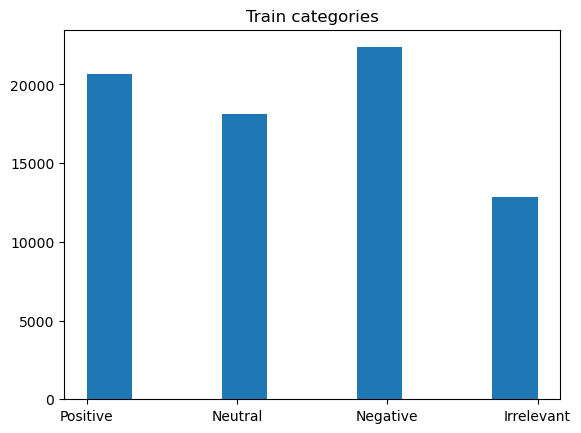

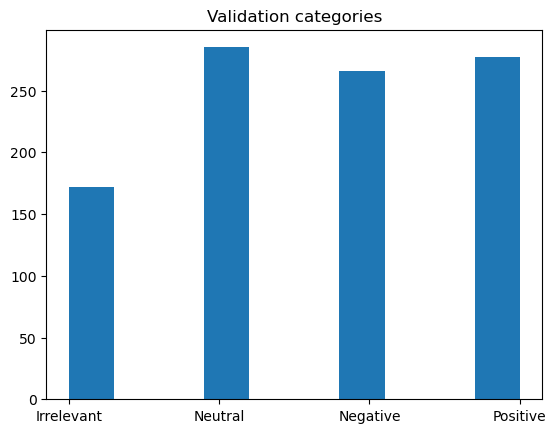

In [11]:
plt.hist(df_train['Sentiment'])
plt.title("Train categories")
plt.show()

plt.hist(df_val['Sentiment'])
plt.title("Validation categories")
plt.show()

In [12]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load("en_core_web_sm")

In [13]:
# Дополнительные стоп слова
additionalStopWords=set((r'\n', 'www','http','@'));

In [14]:
import re
import string

In [15]:
def clean_text(text):
   # удаляем числа
    text = re.sub(r"[^a-zA-Z]", " ", text)
    
   #заменяем на леммы и приводим к нижнему регистру 
    tokenSource = nlp(text)
    tokens = [word.lemma_.lower() for word in tokenSource]
    
    #удаляем пунктуацию
    tokens = [word for word in tokens
              if word not in string.punctuation]
    #убираем стоп-слова
    tokens = [word for word in tokens
              if word not in STOP_WORDS
              and word not in additionalStopWords]
    
    tokens = [word for word in tokens
              if len(word)>2]
    
    return (" ".join(tokens))

In [16]:
df_train['Text'] = df_train['Text'].apply(lambda x:clean_text(x))

In [17]:
df_train.head(5)

,ID,Social network,Sentiment,Text
0,2401,Borderlands,Positive,borderland murder
1,2401,Borderlands,Positive,come border kill
2,2401,Borderlands,Positive,borderland kill
3,2401,Borderlands,Positive,come borderland murder
4,2401,Borderlands,Positive,borderland murder


In [18]:
df_val['Text'] = df_val['Text'].apply(lambda x:clean_text(x))

In [19]:
df_val.head(6)

,ID,Social network,Sentiment,Text
0,3364,Facebook,Irrelevant,mention facebook struggle motivation run day t...
1,352,Amazon,Neutral,bbc news amazon boss jeff bezos reject claim c...
2,8312,Microsoft,Negative,microsoft pay word function poorly samsungus c...
3,4371,CS-GO,Negative,csgo matchmaking closet hack truly awful game
4,4433,Google,Neutral,president slap americans face commit unlawful ...
5,6273,FIFA,Negative,eahelp madeleine mccann cellar past year l...


In [20]:
train_data = df_train['Text'].to_list()
val_data = df_val['Text'].to_list()

In [22]:
train_data = np.concatenate([train_data, val_data])

In [23]:
train_data.shape

(74996,)

In [24]:
train_categ = df_train['Sentiment']
val_categ = df_val['Sentiment']

In [25]:
train_categ

0        Positive
1        Positive
2        Positive
3        Positive
4        Positive
           ...   
74677    Positive
74678    Positive
74679    Positive
74680    Positive
74681    Positive
Name: Sentiment, Length: 73996, dtype: object

In [26]:
val_categ

0      Irrelevant
1         Neutral
2        Negative
3        Negative
4         Neutral
          ...    
995    Irrelevant
996    Irrelevant
997      Positive
998      Positive
999       Neutral
Name: Sentiment, Length: 1000, dtype: object

In [27]:
labels = list(df_train['Sentiment'].unique())
label2id = {v:k for k,v in enumerate(labels)}
print(labels)
print(label2id)

['Positive', 'Neutral', 'Negative', 'Irrelevant']
{'Positive': 0, 'Neutral': 1, 'Negative': 2, 'Irrelevant': 3}


In [28]:
train_targets = np.array(df_train["Sentiment"].map(label2id).to_list())
val_targets = np.array(df_val['Sentiment'].map(label2id).to_list())
train_targets = np.concatenate([train_targets, val_targets])

In [29]:
train_targets.shape

(74996,)

In [30]:
max_len = 128
max_words = 25842
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')  # создаем токенайзер
vocab = tokenizer.fit_on_texts(train_data)   # создаем словарь на основе слов из текста 
sequences = tokenizer.texts_to_sequences(train_data) # преобразуем каждый текст в последовательность чисел

In [31]:
sequences[3]

[32, 112, 1059]

In [32]:
tokenizer.sequences_to_texts(
    sequences[:1])

['borderland murder']

In [33]:
word_index = tokenizer.word_index   # получаем количество уникальных слов
print('Found %s unique tokens'%len(word_index))

Found 25843 unique tokens


In [34]:
train_texts = pad_sequences(sequences, maxlen=max_len)

In [35]:
print(train_texts.shape)

(74996, 128)


In [36]:
indices = np.arange(train_targets.shape[0])    # перемешиваем данные
np.random.shuffle(indices)
train_texts = train_texts[indices]
train_targets = train_targets[indices]
# train test split
test_texts = train_texts[:10_000]
test_targets = train_targets[:10_000]

train_texts = train_texts[10_000:]
train_targets = train_targets[10_000:]

In [37]:
train_targets = to_categorical(train_targets)
test_targets = to_categorical(test_targets)

In [38]:
test_targets

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [39]:
print(f"Train texts shape: {train_texts.shape}")
print(f"Test texts shape: {test_texts.shape}")

Train texts shape: (64996, 128)
Test texts shape: (10000, 128)


In [40]:
print(f"Train targets shape: {train_targets.shape}")
print(f"Test targets shape: {test_targets.shape}")

Train targets shape: (64996, 4)
Test targets shape: (10000, 4)


In [41]:
def build_model():
  model = Sequential()
  model.add(layers.Embedding(input_dim=max_words, output_dim=128))
  model.add(layers.Bidirectional(layers.LSTM(units=128)))
  model.add(layers.Dense(units=64, activation='relu'))  # , kernel_regularizer=L1(0.01)
  model.add(layers.Dense(4, activation='softmax'))

  return model

In [42]:
model = build_model()

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         3307776   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 3,587,652
Trainable params: 3,587,652
Non-trainable params: 0
_________________________________________________________________


In [44]:
for i in model.layers[1].weights:
    print(i.shape)

(128, 512)
(128, 512)
(512,)
(128, 512)
(128, 512)
(512,)


In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
checkpoint = ModelCheckpoint(filepath='weights1.h5', save_best_only = True, monitor='val_loss')
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=3)

In [46]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(), metrics=['acc', AUC()])
history = model.fit(train_texts, train_targets, epochs=10, validation_split=0.2, batch_size=256, callbacks=[checkpoint,lr_scheduler])

Epoch 1/10
204/204 [==============================] - 316s 2s/step - loss: 1.0531 - acc: 0.5631 - auc: 0.8030 - val_loss: 0.8071 - val_acc: 0.6848 - val_auc: 0.8887 - lr: 0.0010
Epoch 2/10
204/204 [==============================] - 299s 1s/step - loss: 0.6024 - acc: 0.7726 - auc: 0.9384 - val_loss: 0.6283 - val_acc: 0.7633 - val_auc: 0.9332 - lr: 0.0010
Epoch 3/10
204/204 [==============================] - 296s 1s/step - loss: 0.4345 - acc: 0.8387 - auc: 0.9677 - val_loss: 0.5058 - val_acc: 0.8095 - val_auc: 0.9564 - lr: 0.0010
Epoch 4/10
204/204 [==============================] - 286s 1s/step - loss: 0.3460 - acc: 0.8694 - auc: 0.9793 - val_loss: 0.4654 - val_acc: 0.8328 - val_auc: 0.9643 - lr: 0.0010
Epoch 5/10
204/204 [==============================] - 282s 1s/step - loss: 0.2911 - acc: 0.8895 - auc: 0.9853 - val_loss: 0.4290 - val_acc: 0.8462 - val_auc: 0.9692 - lr: 0.0010
Epoch 6/10
204/204 [==============================] - 278s 1s/step - loss: 0.2509 - acc: 0.9037 - auc: 0.9889 

In [47]:
model.evaluate(test_texts, test_targets)

313/313 [==============================] - 15s 49ms/step - loss: 0.4524 - acc: 0.8642 - auc: 0.9703


[0.45239052176475525, 0.8641999959945679, 0.9703189730644226]

In [48]:
predictions = model.predict(test_texts, verbose=1)

313/313 [==============================] - 16s 48ms/step
